In [1]:
import pandas as pd
import numpy as np
from scipy.signal import hilbert
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.fft import fft, ifft

c:\Users\blanc\miniconda3\envs\adaexam\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
with open("all_animals_data.pkl", "rb") as f:
    datasets = pickle.load(f)
print(datasets)

{'HW1': {'breath': {'breath': array([[0.27814027, 0.26482999, 0.26353143, ..., 0.        , 0.        ,
        0.        ]]), 'breath_filt': array([[-2.06388626, -1.98763522, -1.91066637, ..., -2.4542347 ,
        -2.4542347 , -2.4542347 ]]), 'valve': array([[0., 0., 0., ..., 0., 0., 0.]]), 'pulse': array([[0., 0., 0., ..., 0., 0., 0.]])}, 'calcium_imaging': {'ca':              0         1         2         3         4         5         6   \
0      0.023819  0.018162  0.011737  0.031267  0.041576  0.025834  0.044826   
1      0.018858  0.032161  0.030480  0.060123  0.053348  0.020066  0.063815   
2      0.023240  0.042044  0.039762  0.046580  0.047504 -0.005441  0.028765   
3      0.023523  0.030001  0.025756  0.047008  0.073638  0.004797  0.039966   
4      0.030514  0.052289  0.061530  0.046940  0.044228  0.004096  0.042574   
...         ...       ...       ...       ...       ...       ...       ...   
21187  0.016760  0.031136  0.045534  0.033281  0.020383  0.016297  0.035301   


In [3]:
fs_breath = 1000 
fs_calcium = 10

animals = []
breath = []
breath_filt = []
valve_data = []
pulse_data = []
calcium_ds = []
ca_interp_ds = []

t_breath = []
t_pulse = []
t_calcium = []

for key, _ in datasets.items():

    animals.append(key)
    breath.append(datasets[key]['breath']['breath'].flatten())
    breath_filt.append(datasets[key]['breath']['breath_filt'].flatten())
    valve_data.append(datasets[key]['breath']['valve'].flatten())
    pulse_data.append(datasets[key]['breath']['pulse'].flatten())
    calcium_ds.append(datasets[key]['calcium_imaging']['ca'])
    ca_interp_ds.append(datasets[key]['calcium_imaging']['ca_nn_interp'])

    t_breath.append(np.arange(len(datasets[key]['breath']['breath'].flatten())) / fs_breath)
    t_pulse.append(np.arange(len(datasets[key]['breath']['pulse'].flatten())) / fs_breath)
    t_calcium.append(np.arange(len(datasets[key]['calcium_imaging']['ca']))/ fs_calcium)

breath_dict = dict(zip(animals, breath))
breath_filt_dict = dict(zip(animals, breath_filt))
valve_dict = dict(zip(animals, valve_data))
pulse_dict = dict(zip(animals, pulse_data))
calcium_dict = dict(zip(animals, calcium_ds))
ca_interp_dict = dict(zip(animals, ca_interp_ds))


In [4]:
analytic_signal = []
amplitude_env = []
instant_phase = []
instant_freq = []

for i, key in enumerate(breath_filt_dict.keys()):
    analytic_signal.append(hilbert(breath_filt_dict[key]))
    amplitude_env.append(np.abs(analytic_signal[i]))
    instant_phase.append(np.angle(analytic_signal[i]))
    instant_freq.append(np.diff(instant_phase[i]) / (2.0*np.pi) * fs_breath)

analytic_signal_dict = dict(zip(animals, analytic_signal))
amplitude_env_dict = dict(zip(animals, amplitude_env))
instant_phase_dict = dict(zip(animals, instant_phase))
instant_freq_dict = dict(zip(animals, instant_freq))

#### FFT Transformation

In [7]:
ca = ca_interp_dict['HW1'].mean(axis=1).to_numpy()
odor_pulse = valve_dict['HW1']/100
breath_phase = instant_phase_dict['HW1']

T = len(ca)

max_lag = 1000
n_phase_bins = 10

phase_bins = np.linspace(-np.pi, np.pi, n_phase_bins + 1)
phase_indices = np.digitize(breath_phase, phase_bins) - 1

rc_2d = np.zeros((max_lag, n_phase_bins))
    
for lag in range(max_lag):
    products = ifft(fft(ca[lag+1:]) * np.conj(fft(odor_pulse[:-(lag+1)]))).real
    np.add.at(rc_2d[lag], phase_indices[lag+1:], products) 
    print(f'done for {lag}')

pulse_sum = np.sum(odor_pulse)
if pulse_sum > 0:
    rc_2d /= pulse_sum

done for 0
done for 1
done for 2
done for 3
done for 4
done for 5
done for 6
done for 7
done for 8
done for 9
done for 10
done for 11
done for 12
done for 13
done for 14
done for 15
done for 16
done for 17
done for 18
done for 19
done for 20
done for 21
done for 22
done for 23
done for 24
done for 25
done for 26
done for 27
done for 28
done for 29
done for 30
done for 31
done for 32
done for 33
done for 34
done for 35
done for 36
done for 37
done for 38
done for 39
done for 40
done for 41
done for 42
done for 43
done for 44
done for 45
done for 46
done for 47
done for 48
done for 49
done for 50
done for 51
done for 52
done for 53
done for 54
done for 55
done for 56
done for 57
done for 58
done for 59
done for 60
done for 61
done for 62
done for 63
done for 64
done for 65
done for 66
done for 67
done for 68
done for 69
done for 70
done for 71
done for 72
done for 73
done for 74
done for 75
done for 76
done for 77
done for 78
done for 79
done for 80
done for 81
done for 82
done for 83
do

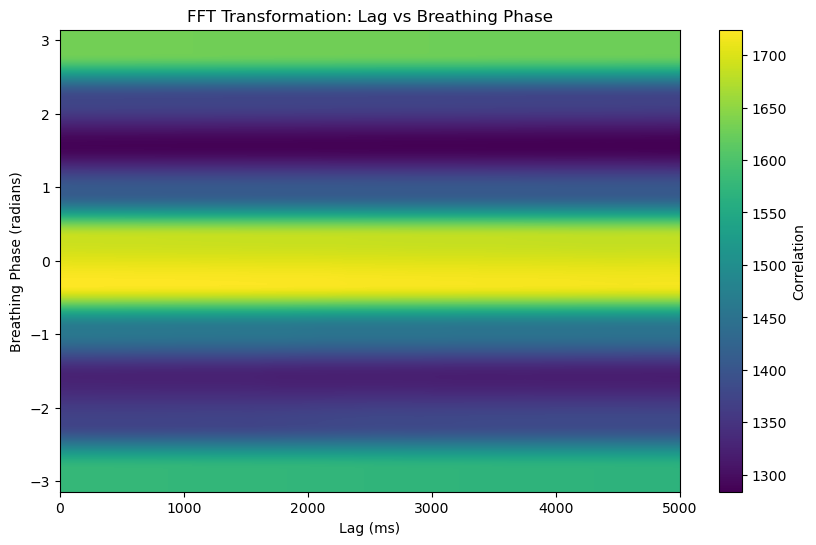

In [36]:
plt.figure(figsize=(10, 6))
plt.imshow(rc_2d.T, aspect='auto', origin='lower', 
           extent=[0, max_lag, -np.pi, np.pi])
plt.colorbar(label='Correlation')
plt.title('FFT Transformation: Lag vs Breathing Phase')
plt.xlabel('Lag (ms)')
plt.ylabel('Breathing Phase (radians)')
plt.show()

#### Phase-Dependent Lagged Stimulus-Response Filter Estimation

In [5]:
from joblib import Parallel, delayed
from scipy.signal import butter, filtfilt

In [10]:
from scipy.signal import medfilt

ca = ca_interp_dict['HW1'].mean(axis=1).to_numpy()

smoothed_signal = medfilt(ca, kernel_size=501)

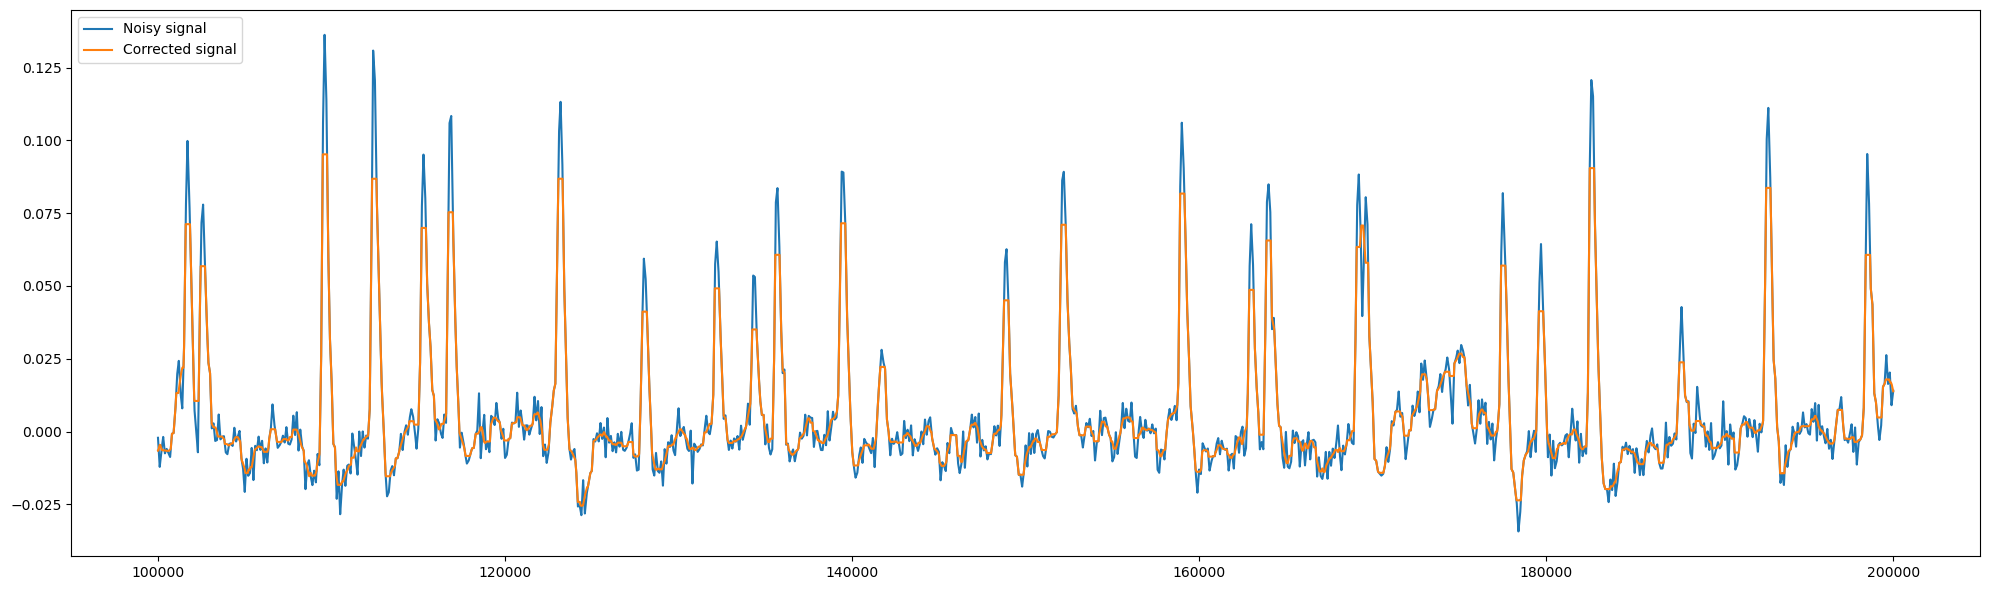

In [11]:
plt.figure(figsize=(20, 6))
time = np.arange(len(ca))
plt.plot(time[100000:200000], ca[100000:200000], label=f'Noisy signal')
plt.plot(time[100000:200000], smoothed_signal[100000:200000], label=f'Corrected signal')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Method:
Evaluates the contribution of past stimuli at varying lags and breath phases to neural activity using a weighted average of response-to-stimulus ratios

In [12]:
ca = ca_interp_dict['HW1'].mean(axis=1).to_numpy()
odor_pulse = valve_dict['HW1']/100
breath_phase = instant_phase_dict['HW1']

max_lag = 1000
time_lags = np.arange(0, max_lag)  
n_bins = 15                      
bin_edges = np.linspace(-np.pi, np.pi, n_bins + 1) 
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

lambda_reg = 1e-4                  

discrete_phase = np.digitize(breath_phase, bin_edges) - 1 

chunk_size = 5000  
n_chunks = len(ca) // chunk_size + 1

In [13]:
# Function to compute filter for a single (tau, phi) pair with regularizatio
def compute_filter_with_regularization(tau, phi_idx):
    mask_current_phi = discrete_phase == phi_idx
    mask_past_phi = np.roll(mask_current_phi, tau)

    f_tau_phi_val = 0
    count = 0
    for i in range(n_chunks):
        start = i * chunk_size
        end = min((i + 1) * chunk_size, len(ca))

        valid_indices = (odor_pulse[start:end] *
                         mask_current_phi[start:end] *
                         mask_past_phi[start:end]).astype(bool)

        if np.any(valid_indices):
            response_subset = ca[start:end][valid_indices]
            stimulus_subset = odor_pulse[start:end][valid_indices]
            f_tau_phi_val += np.sum(response_subset * stimulus_subset)
            count += np.sum(stimulus_subset**2)
    
    # Add regularization term
    count += lambda_reg
    return f_tau_phi_val / count if count > 0 else 0


In [14]:
# Parallelized computation of the regularized filter matrix
def compute_filter_matrix_with_regularization():
    f_tau_phi = np.zeros((len(time_lags), n_bins))
    results = Parallel(n_jobs=-1)(
        delayed(compute_filter_with_regularization)(tau, phi_idx)
        for tau_idx, tau in enumerate(time_lags)
        for phi_idx in range(n_bins)
    )

    for tau_idx, tau in enumerate(time_lags):
        for phi_idx in range(n_bins):
            f_tau_phi[tau_idx, phi_idx] = results[tau_idx * n_bins + phi_idx]
    return f_tau_phi

In [67]:
# compute filter for a single (tau, phi) pair
def compute_filter(ca, tau, phi_idx):
    mask_current_phi = discrete_phase == phi_idx # time when the breath phase equals the current phase bin
    mask_past_phi = np.roll(mask_current_phi, tau) # focus on past time points (delayed by tau)
    
    f_tau_phi_val = 0
    count = 0
    for i in range(n_chunks):
        start = i * chunk_size
        end = min((i + 1) * chunk_size, len(ca))
        
        # identify points where the current phase is equal to phi and the past phase equals to phi
        valid_indices = (odor_pulse[start:end] *mask_current_phi[start:end] *mask_past_phi[start:end]).astype(bool)
        
        if np.any(valid_indices):
            response_subset = ca[start:end][valid_indices] # extract the corresponding response vector and stimulus
            stimulus_subset = odor_pulse[start:end][valid_indices]
            f_tau_phi_val += np.sum(response_subset / stimulus_subset) #accumulate the contribution
            count += np.sum(valid_indices)
    
    return f_tau_phi_val / count if count > 0 else 0 # mean contribution r(t)/s(t) normalized by the count of valid points

In [68]:
#computate of the filter matrix with every tau phi pair 
def compute_filter_matrix(ca):
    f_tau_phi = np.zeros((len(time_lags), n_bins)) # store the values for each combination of lag and phase
    results = Parallel(n_jobs=-1)(
        delayed(compute_filter)(ca, tau, phi_idx)
        for tau_idx, tau in enumerate(time_lags)
        for phi_idx in range(n_bins)
    )

    for tau_idx, tau in enumerate(time_lags):
        for phi_idx in range(n_bins):
            f_tau_phi[tau_idx, phi_idx] = results[tau_idx * n_bins + phi_idx]
    return f_tau_phi

In [15]:
f_tau_phi_regularized = compute_filter_matrix_with_regularization()

In [80]:
f_tau_phi = compute_filter_matrix(smoothed_signal)

In [124]:
# Compute the filter
f_tau_phi = compute_filter_matrix(ca)

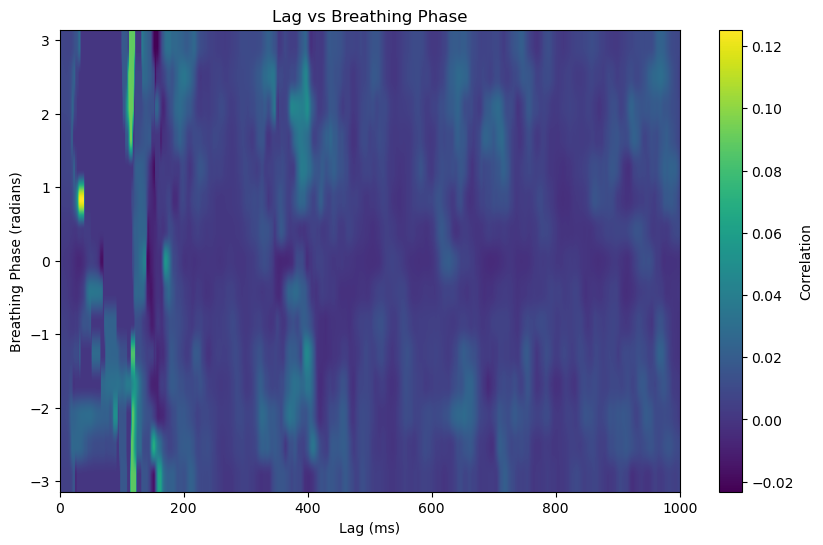

In [16]:
plt.figure(figsize=(10, 6))
plt.imshow(f_tau_phi_regularized.T, aspect='auto', origin='lower', 
           extent=[0, max_lag, -np.pi, np.pi])
plt.colorbar(label='Correlation')
plt.title('Lag vs Breathing Phase')
plt.xlabel('Lag (ms)')
plt.ylabel('Breathing Phase (radians)')
plt.show()

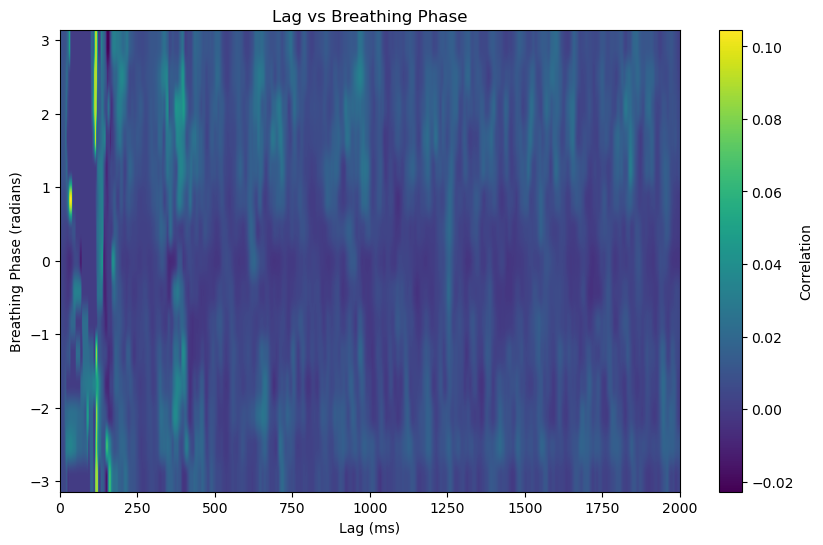

In [81]:
plt.figure(figsize=(10, 6))
plt.imshow(f_tau_phi.T, aspect='auto', origin='lower', 
           extent=[0, max_lag, -np.pi, np.pi])
plt.colorbar(label='Correlation')
plt.title('Lag vs Breathing Phase')
plt.xlabel('Lag (ms)')
plt.ylabel('Breathing Phase (radians)')
plt.show()

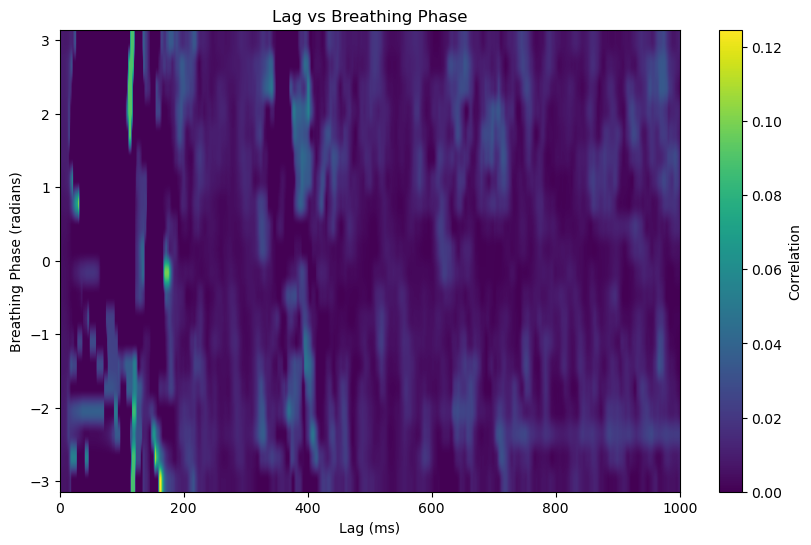

In [146]:
plt.figure(figsize=(10, 6))
plt.imshow(f_tau_phi.T, aspect='auto', origin='lower', 
           extent=[0, max_lag, -np.pi, np.pi])
plt.colorbar(label='Correlation')
plt.title('Lag vs Breathing Phase')
plt.xlabel('Lag (ms)')
plt.ylabel('Breathing Phase (radians)')
plt.show()

#### Plotting the kernel for each phase bin

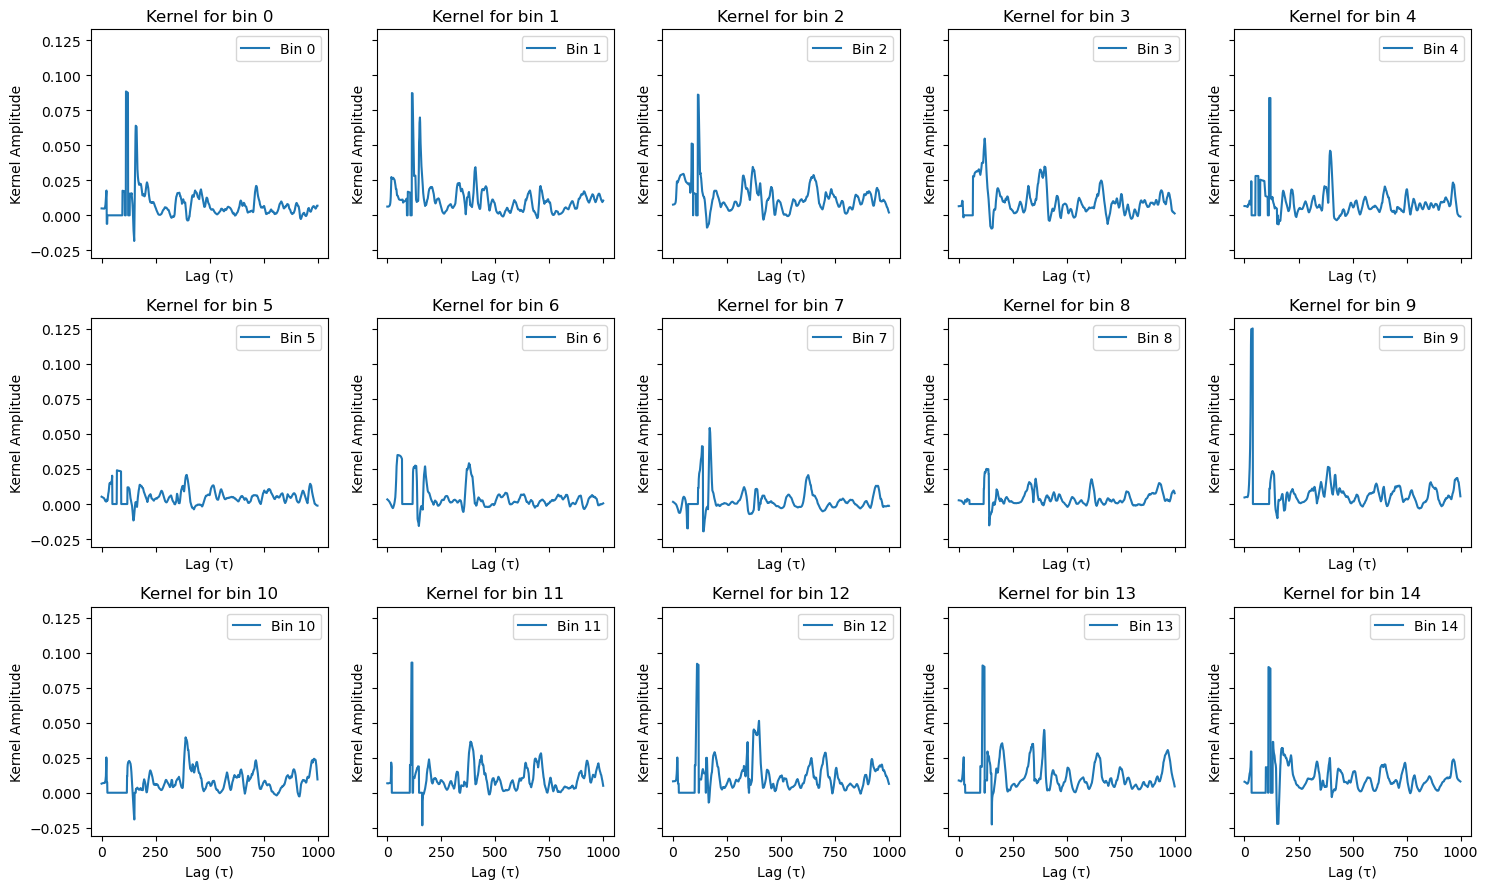

In [17]:
n_bins = len(f_tau_phi_regularized[0])  
ncols = 5
nrows = (n_bins + ncols - 1) // ncols  

fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3), sharex=True, sharey=True)

axes = axes.flatten()

for i in range(n_bins):
    axes[i].plot(f_tau_phi_regularized.T[i])
    axes[i].set_title(f'Kernel for bin {i}')
    axes[i].set_xlabel('Lag (τ)')
    axes[i].set_ylabel('Kernel Amplitude')
    axes[i].legend([f'Bin {i}'])

for i in range(n_bins, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


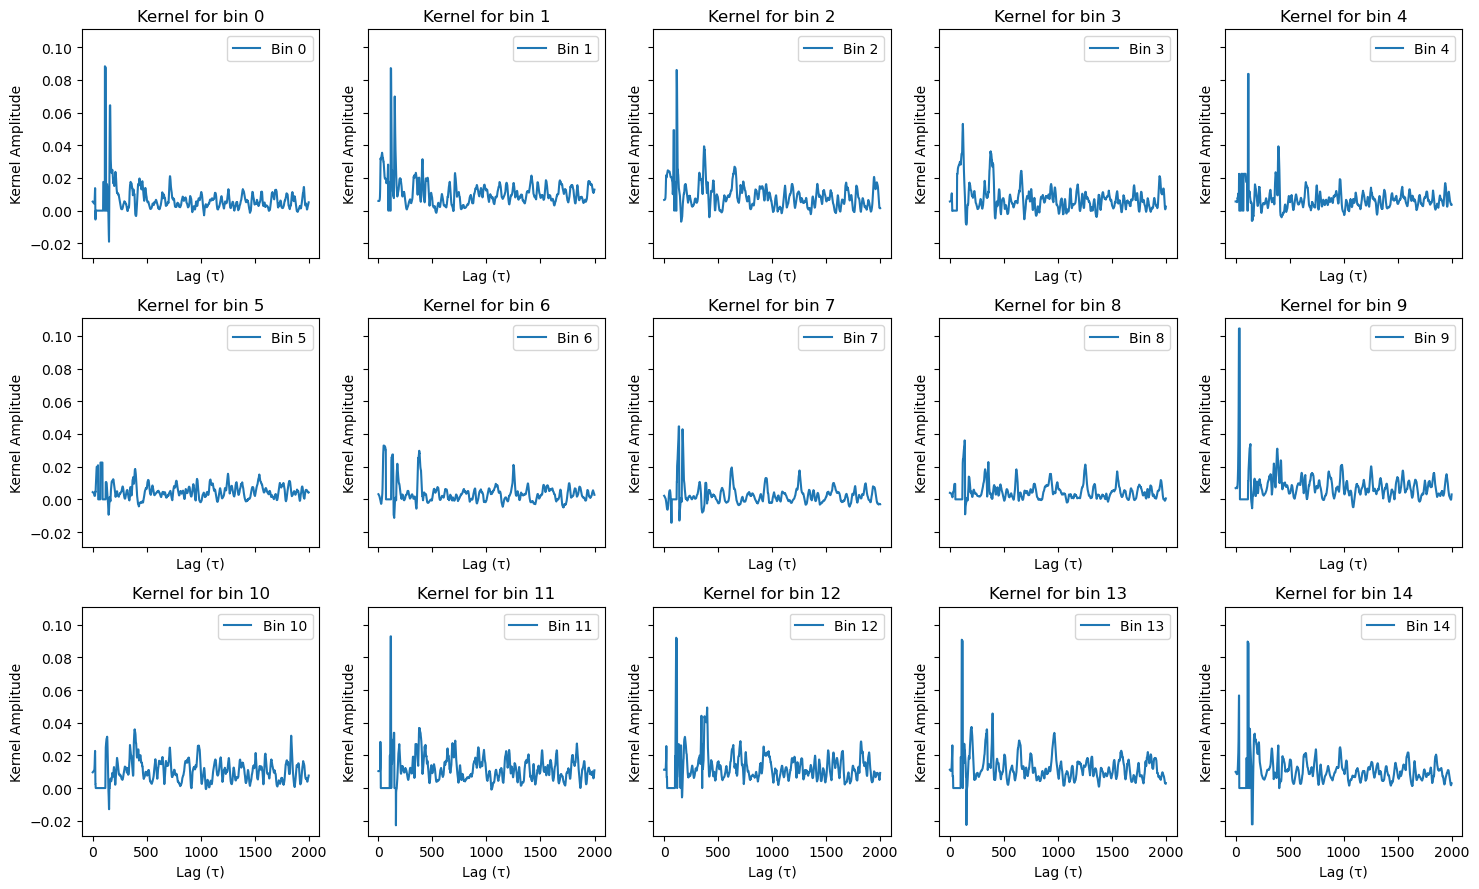

In [82]:
n_bins = len(f_tau_phi[0])  
ncols = 5
nrows = (n_bins + ncols - 1) // ncols  

fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3), sharex=True, sharey=True)

axes = axes.flatten()

for i in range(n_bins):
    axes[i].plot(f_tau_phi.T[i])
    axes[i].set_title(f'Kernel for bin {i}')
    axes[i].set_xlabel('Lag (τ)')
    axes[i].set_ylabel('Kernel Amplitude')
    axes[i].legend([f'Bin {i}'])

for i in range(n_bins, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


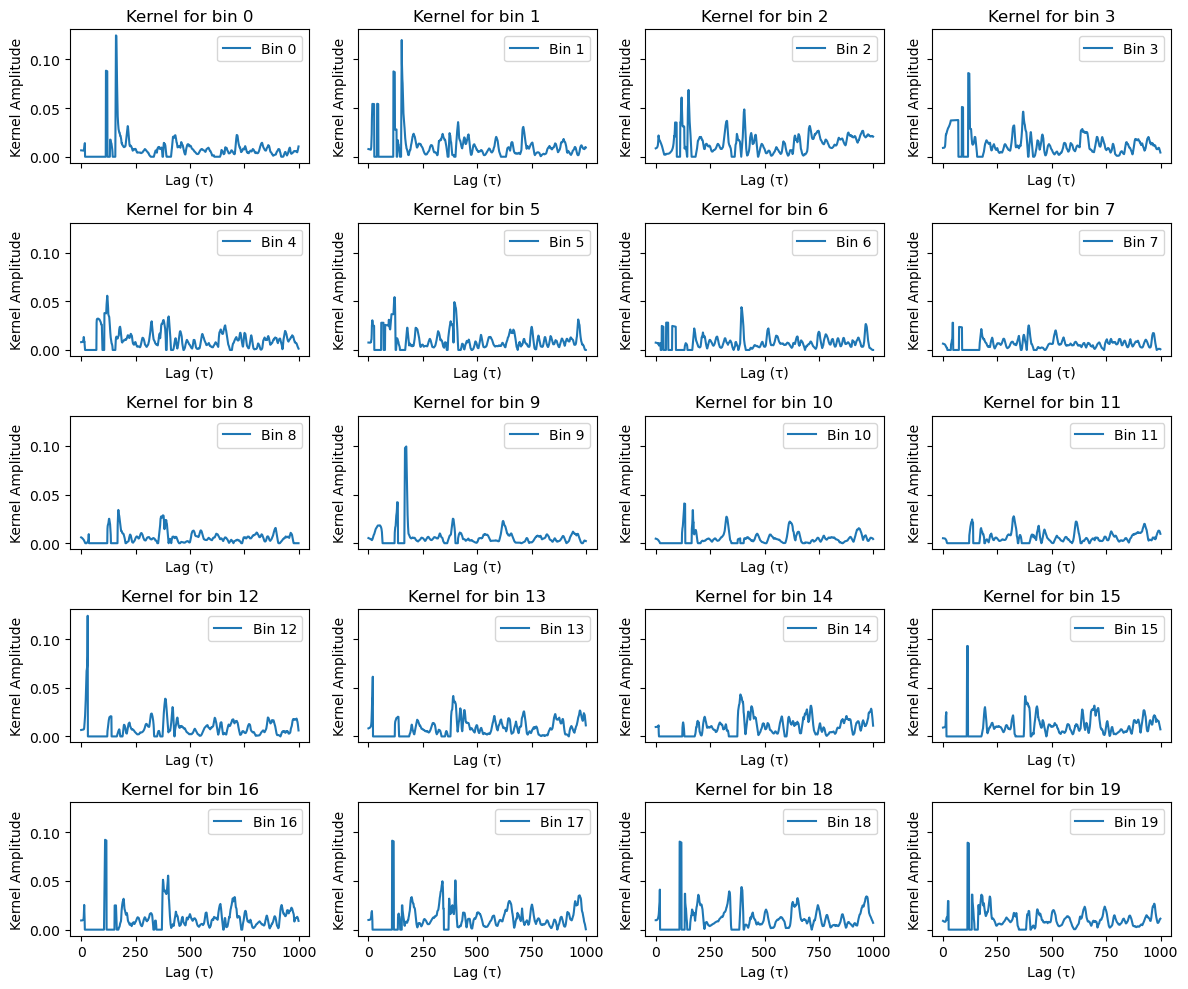

In [152]:
n_bins = len(f_tau_phi[0])  
ncols = 4 
nrows = (n_bins + ncols - 1) // ncols  

fig, axes = plt.subplots(nrows, ncols, figsize=(12, nrows * 2), sharex=True, sharey=True)

axes = axes.flatten()

for i in range(n_bins):
    axes[i].plot(f_tau_phi.T[i])
    axes[i].set_title(f'Kernel for bin {i}')
    axes[i].set_xlabel('Lag (τ)')
    axes[i].set_ylabel('Kernel Amplitude')
    axes[i].legend([f'Bin {i}'])

for i in range(n_bins, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Observations:
- some phase bins exhbit distinct peaks -> the filter seem to capture some phase dependant sensitivities to the stimulus pulses 
- multiple peaks for some phase bins: some stimuli may participate in later ca responses
- phase bins with no peaks (flat kernels): effectively captures the phases when the neurons are insesnitve to pulses

Problems: 
- High noise for each kernel 

To try:
- Preprocess the ca data better? Remove baseline noise? 
- Lessen the number of bins to have more data points per bin

In [147]:
def predict_response(pulse, breath_phase, rc_2d, max_lag, n_phase_bins):
    phase_bins = np.linspace(-np.pi, np.pi, n_phase_bins + 1)
    phase_indices = np.digitize(breath_phase, phase_bins) - 1
    
    predicted_response = np.zeros(len(pulse))
    print(len(pulse))
    
    for t in range(max_lag, len(pulse)):
        for lag in range(max_lag):
            predicted_response[t] += rc_2d[lag, phase_indices[t-lag]] * pulse[t-lag]
    
    return predicted_response

predicted_ca = predict_response(odor_pulse[50000:150000], breath_phase[50000:150000], f_tau_phi, max_lag, n_phase_bins)

100000


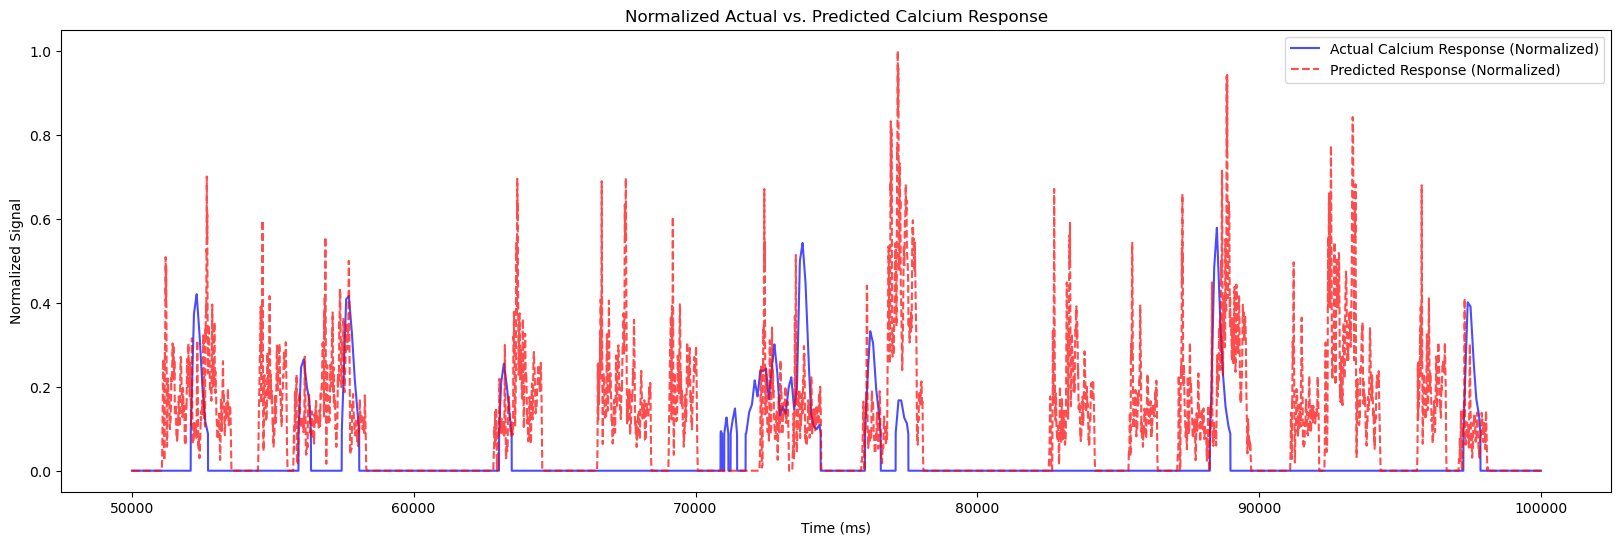

In [151]:
ca_response_norm = (ca - np.min(ca)) / (np.max(ca) - np.min(ca))
predicted_response_norm = (predicted_ca - np.min(predicted_ca)) / (np.max(predicted_ca) - np.min(predicted_ca))

plt.figure(figsize=(20, 6))
time = np.arange(len(ca))
plt.plot(time[50000:100000], ca_response_norm[50000:100000], label='Actual Calcium Response (Normalized)', color='blue', alpha=0.7)
plt.plot(time[50000:100000], predicted_response_norm[0:50000], label='Predicted Response (Normalized)', color='red', linestyle='--', alpha=0.7)
plt.title('Normalized Actual vs. Predicted Calcium Response')
plt.xlabel('Time (ms)')
plt.ylabel('Normalized Signal')
plt.legend()
plt.show()

#### LNP

In [132]:
from scipy.optimize import minimize

def lnp_model_efficient(params, stimulus, response, f_tau_phi, phase_indices, max_lag):

    bias = params[0]
    scale = params[1]

    num_chunks = len(stimulus) // chunk_size + 1
    linear_response = np.zeros(len(stimulus))
    
    for chunk_idx in range(num_chunks):
        start = chunk_idx * chunk_size
        end = min((chunk_idx + 1) * chunk_size, len(stimulus))

        stimulus_chunk = stimulus[start:end]
        phase_indices_chunk = phase_indices[start:end]

        for lag in range(max_lag):
            shifted_stimulus = np.roll(stimulus_chunk, lag)
            phase_bins_lag = np.roll(phase_indices_chunk, lag)

            linear_response[start:end] += f_tau_phi[lag, phase_bins_lag] * shifted_stimulus

        print(f'done for chunk {chunk_idx}')

    nonlinear_response = np.exp(scale * linear_response + bias)

    # Compute Negative Log-Likelihood (Poisson model)
    nll = -np.sum(response * np.log(nonlinear_response + 1e-8) - nonlinear_response)
    return nll

init_params = np.array([0.1, 1.0]) 

result = minimize(
    lnp_model_efficient,
    init_params,
    args=(odor_pulse, ca, f_tau_phi, phase_indices, max_lag),
    method="L-BFGS-B",
    options={"disp": True}
)

optimal_params = result.x
bias = optimal_params[0]
scale = optimal_params[1]


done for chunk 0
done for chunk 1
done for chunk 2
done for chunk 3
done for chunk 4
done for chunk 5
done for chunk 6
done for chunk 7
done for chunk 8
done for chunk 9
done for chunk 10
done for chunk 11
done for chunk 12
done for chunk 13
done for chunk 14
done for chunk 15
done for chunk 16
done for chunk 17
done for chunk 18
done for chunk 19
done for chunk 20
done for chunk 21
done for chunk 22
done for chunk 23
done for chunk 24
done for chunk 25
done for chunk 26
done for chunk 27
done for chunk 28
done for chunk 29
done for chunk 30
done for chunk 31
done for chunk 32
done for chunk 33
done for chunk 34
done for chunk 35
done for chunk 36
done for chunk 37
done for chunk 38
done for chunk 39
done for chunk 40
done for chunk 41
done for chunk 42
done for chunk 43
done for chunk 44
done for chunk 45
done for chunk 46
done for chunk 47
done for chunk 48
done for chunk 49
done for chunk 50
done for chunk 51
done for chunk 52
done for chunk 53
done for chunk 54
done for chunk 55
do

In [134]:
def predict_lnp_efficient(stimulus, f_tau_phi, phase_indices, max_lag, bias, scale):

    num_chunks = len(stimulus) // chunk_size + 1
    linear_response = np.zeros(len(stimulus))

    for chunk_idx in range(num_chunks):
        start = chunk_idx * chunk_size
        end = min((chunk_idx + 1) * chunk_size, len(stimulus))

        stimulus_chunk = stimulus[start:end]
        phase_indices_chunk = phase_indices[start:end]

        for lag in range(max_lag):
            shifted_stimulus = np.roll(stimulus_chunk, lag)
            phase_bins_lag = np.roll(phase_indices_chunk, lag)

            linear_response[start:end] += f_tau_phi[lag, phase_bins_lag] * shifted_stimulus

    predicted_response = np.exp(scale * linear_response + bias)
    return predicted_response

predicted_response = predict_lnp_efficient(
    odor_pulse, f_tau_phi, phase_indices, max_lag, bias, scale
)

# Output Results
print("Optimized Bias:", bias)
print("Optimized Scale:", scale)

Optimized Bias: -5.165235263549666
Optimized Scale: 1.1185218906128147


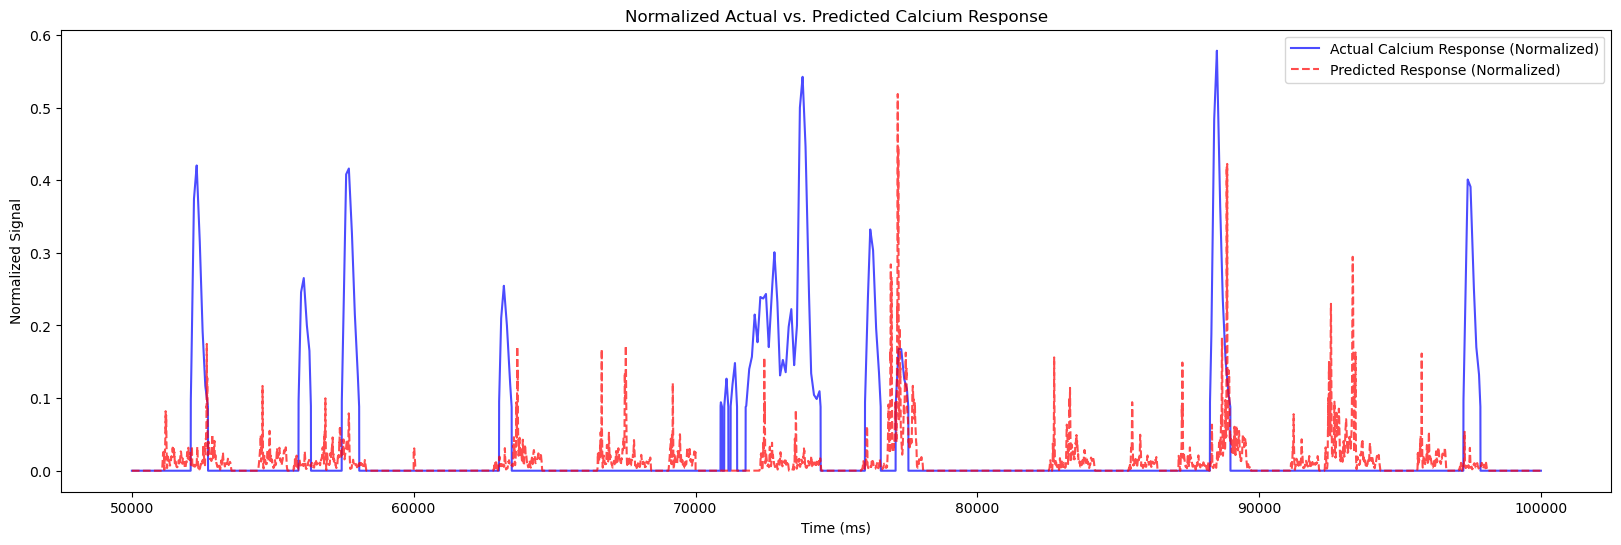

In [144]:
ca_response_norm = (ca - np.min(ca)) / (np.max(ca) - np.min(ca))
predicted_response_norm = (predicted_response - np.min(predicted_response)) / (np.max(predicted_response) - np.min(predicted_response))

plt.figure(figsize=(20, 6))
time = np.arange(len(ca))
plt.plot(time[50000:100000], ca_response_norm[50000:100000], label='Actual Calcium Response (Normalized)', color='blue', alpha=0.7)
plt.plot(time[50000:100000], 3*predicted_response_norm[50000:100000], label='Predicted Response (Normalized)', color='red', linestyle='--', alpha=0.7)
plt.title('Normalized Actual vs. Predicted Calcium Response')
plt.xlabel('Time (ms)')
plt.ylabel('Normalized Signal')
plt.legend()
plt.show()